In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 10  # pixels/um

sx = 16  # size of cell in X direction
sy = 32  # size of cell in Y direction
cell = mp.Vector3(sx, sy, 0)

dpml = 1.0
pml_layers = [mp.PML(dpml)]

In [2]:
pad = 4 # Pad distance between waveguide and cell edge
w = 1 # width of waveguide

In [3]:
wvg_xcen = .5 * (sx - w - 2 * pad) # x center of horiz wvg
wvg_ycen = -.5 * (sy - w - 2 * pad) # y center of vert wvg

In [4]:
wvg_xcen, wvg_ycen

(3.5, -11.5)

In [5]:
geometry = [
    mp.Block(
        size=mp.Vector3(mp.inf, w, mp.inf),
        center=mp.Vector3(0,wvg_ycen,0),
        material=mp.Medium(epsilon=12)
    )
]

In [6]:
fcen = .15
# fcen = .1
# fcen = .06
df = .1
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(-0.5 * sx + dpml, wvg_ycen, 0),
        size=mp.Vector3(0,w,0)
    )
]

     block, center = (0,-11.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


/home/tornikeo/miniconda3/envs/vortex/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/tornikeo/miniconda3/envs/vortex/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


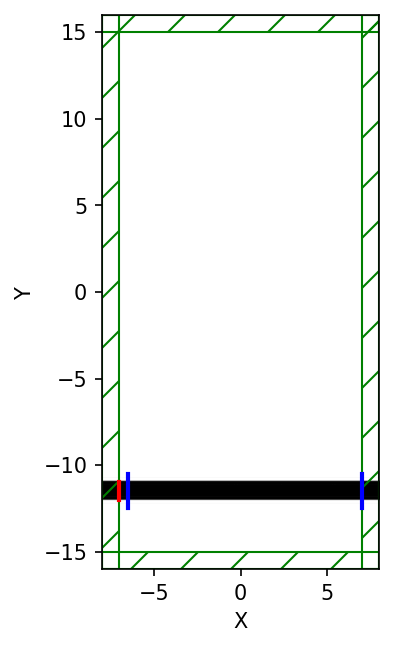

In [7]:
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

nfreq = 100

# Reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-0.5*sx + dpml + 0.5, wvg_ycen, 0),
    size=mp.Vector3(0, 2*w, 0)
)

refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(
    center=mp.Vector3(0.5 * sx - dpml, wvg_ycen, 0),
    size=mp.Vector3(0, 2 * w, 0)
)

tran = sim.add_flux(fcen, df, nfreq, tran_fr)
plt.figure(dpi=150,)
sim.plot2D()
plt.show();

In [8]:
import time

pt = mp.Vector3(0.5 * sx - dpml - 0.5, wvg_ycen)

f = plt.figure(dpi=150)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
sim.run(
    mp.at_every(10, Animate),
    until_after_sources = mp.stop_when_fields_decayed(
        dt=50, c=mp.Ez, pt=pt, decay_by=1e-3,)
)
plt.close()
!mkdir -p media
filename = f'media/{time.strftime("%Y%m%d-%H%M%S")}.mp4'
fps = 10
Animate.to_mp4(fps, filename)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000105858 s
Working in 2D dimensions.
Computational cell is 16 x 32 x 0 with resolution 10
     block, center = (0,-11.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0547099 s
-----------
     block, center = (0,-11.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
field decay(t = 50.050000000000004): 4.825189380557793e-09 / 4.825189380557793e-09 = 1.0
field decay(t = 100.05000000000001): 0.0288018098794258 / 0.0288018098794258 = 1.0
field decay(t = 150.1): 0.026893465093385728 / 0.0288018098794258 = 0.933742192104279
field decay(t = 200.15): 2.3158397323771355e-13 / 0.0288018098794258 = 8.040604885845821e-12
Normalizing field data...
run 0 finished at t = 200.15 (4003 timesteps)
Generating MP4...


In [9]:
from IPython.display import Video
Video(filename)

In [10]:
straight_refl_data = sim.get_flux_data(refl)

In [11]:
straight_tran_flux = mp.get_fluxes(tran)

In [12]:
sim.reset_meep()

geometry = [
    mp.Block(
        mp.Vector3(sx - pad, w, mp.inf),
        center=mp.Vector3(-0.5 * pad, wvg_ycen),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(w, sy - pad, mp.inf),
        center=mp.Vector3(wvg_xcen, 0.5 * pad),
        material=mp.Medium(epsilon=12),
    ),
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(
    center=mp.Vector3(wvg_xcen, 0.5 * sy - dpml - 0.5, 0), size=mp.Vector3(2 * w, 0, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3(wvg_xcen, 0.5 * sy - dpml - 0.5)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000152111 s
Working in 2D dimensions.
Computational cell is 16 x 32 x 0 with resolution 10
     block, center = (-2,-11.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,28,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0606599 s
-----------


In [13]:
tran_fr

In [14]:


# plt.figure(dpi=150)
# sim.plot2D()
# plt.show()

Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
sim.run(
    mp.at_every(10, Animate),
    until_after_sources = mp.stop_when_fields_decayed(
        dt=50, c=mp.Ez, pt=pt, decay_by=1e-3,)
)
plt.close()
!mkdir -p media
filename = f'media/{time.strftime("%Y%m%d-%H%M%S")}.mp4'
fps = 10
Animate.to_mp4(fps, filename)

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

     block, center = (-2,-11.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,28,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
field decay(t = 50.050000000000004): 1.6976522694449004e-10 / 1.6976522694449004e-10 = 1.0
field decay(t = 100.05000000000001): 4.6910710639105397e-07 / 4.6910710639105397e-07 = 1.0
field decay(t = 150.1): 2.9928727336863423e-07 / 4.6910710639105397e-07 = 0.6379934758846828
field decay(t = 200.15): 0.003927813565272273 / 0.003927813565272273 = 1.0
field decay(t = 250.20000000000002): 0.00015009081939074004 / 0.003927813565272273 = 0.03821230740627982
field decay(t = 300.2): 8.806226395602308e-11 / 0.003927813565272273 = 2.242017409752458e-08
Normalizing field data...
run 0 finished at t = 300.2 (6004 timesteps)
Generating MP4...


In [15]:
Video(filename)

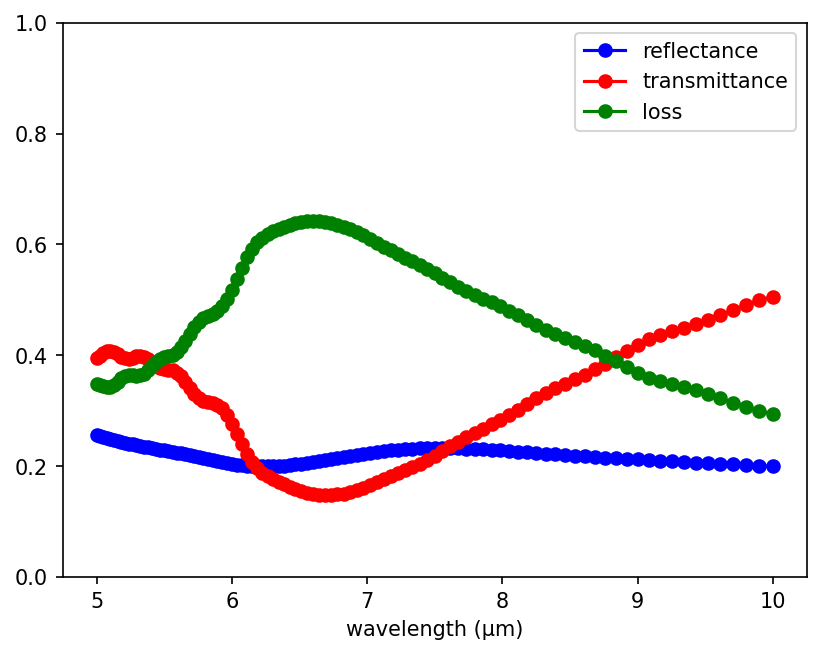

In [16]:
wl = []
Rs = []
Ts = []

for i in range(nfreq):
    wl = np.append(wl, 1 / flux_freqs[i])
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])
    

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label="reflectance")
    plt.plot(wl, Ts, "ro-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
#     plt.axis([5.0, 10.0, 0, 1])
    plt.ylim([0,1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

In [20]:
flux_freqs

[0.09999999999999999,
 0.10101010101010101,
 0.10202020202020201,
 0.10303030303030303,
 0.10404040404040403,
 0.10505050505050505,
 0.10606060606060605,
 0.10707070707070707,
 0.10808080808080807,
 0.10909090909090909,
 0.11010101010101009,
 0.1111111111111111,
 0.11212121212121212,
 0.11313131313131312,
 0.11414141414141414,
 0.11515151515151514,
 0.11616161616161616,
 0.11717171717171716,
 0.11818181818181818,
 0.11919191919191918,
 0.1202020202020202,
 0.12121212121212122,
 0.12222222222222222,
 0.12323232323232322,
 0.12424242424242424,
 0.12525252525252525,
 0.12626262626262627,
 0.12727272727272726,
 0.12828282828282828,
 0.1292929292929293,
 0.1303030303030303,
 0.13131313131313133,
 0.13232323232323231,
 0.13333333333333333,
 0.13434343434343435,
 0.13535353535353534,
 0.13636363636363635,
 0.13737373737373737,
 0.1383838383838384,
 0.1393939393939394,
 0.14040404040404042,
 0.1414141414141414,
 0.14242424242424243,
 0.14343434343434344,
 0.14444444444444443,
 0.14545454545454

In [18]:
1/10

0.1

In [19]:
fcen

0.15